In [1]:
import pandas as pd
import numpy as np
import re
import math
from tqdm import tqdm
from collections import Counter

## Data Preprocessing

1. Из карточки найти пациентов с ожирением (либо по слову "ожирение", либо по коду МКБ)

In [2]:
path = 'Obesity/I10_01012015-20210707_all_records.txt'

In [3]:
CHUNK_SIZE = 1000

df_iterator = pd.read_csv(
    path, 
    sep='\t',
    encoding='cp1251',
    chunksize=CHUNK_SIZE)

In [4]:
data = [chunk for chunk in df_iterator]

In [5]:
for i in tqdm(range(len(data))):
    df = data[i]
    data[i] = df[df['RecordEMC'].notna()]

100%|███████████████████████████████████| 11329/11329 [00:07<00:00, 1555.72it/s]


In [6]:
data[0]

,Name,MedicalProcessEventCode,СompletionDate,СompletionTime,SpecialistName,Organization,Department,SpecialistType,EventType,Event,EMCSection,RecordEMC,ExecutionStatus,StartEpizode,EndEpizode,GoalAdmission,TypeAdmission
0,GACAAAY,GACAAAYAAAAbk12:45AAAA,20111206,12:45,Жукова_Ирина_Николаевна,Центр_Алмазова,ООПМУ,Медицинский_регистратор,NaN,Ввод_назначений (Консультация),ИСТОЧНИК_ФИНАНСИРОВАНИЯ,Тип : ДМС Тарифный_план : Все_услуги Плательщи...,выполнено,NaN,20120116.0,NaN,АМБУЛАТОРНО
1,GACAAAY,GACAAAYAAAAbs11:30-cAD,20111214,11:30-12:00,Сапрыкина_Галина_Дмитриевна,Центр_Алмазова,Кар,Врач-кардиолог,NaN,"Прием_(осмотр,_консультация)_врача-кардиолога_...",ЖАЛОБЫ,"При измерении АД выявил нерегул. ритм с 2008г,...",выполнено,NaN,20120116.0,NaN,АМБУЛАТОРНО
2,GACAAAY,GACAAAYAAAAbs11:30-cAG,20111214,11:30-12:00,Сапрыкина_Галина_Дмитриевна,Центр_Алмазова,Кар,Врач-кардиолог,NaN,"Прием_(осмотр,_консультация)_врача-кардиолога_...",ЖАЛОБЫ,"АД чаще нормальное-130\60, редко-160\100.",выполнено,NaN,20120116.0,NaN,АМБУЛАТОРНО
3,GACAAAY,GACAAAYAAAAbs11:30-cAJ,20111214,11:30-12:00,Сапрыкина_Галина_Дмитриевна,Центр_Алмазова,Кар,Врач-кардиолог,NaN,"Прием_(осмотр,_консультация)_врача-кардиолога_...",ЖАЛОБЫ,"Ходит быстро, болей. одышки нет.",выполнено,NaN,20120116.0,NaN,АМБУЛАТОРНО
4,GACAAAY,GACAAAYAAAAbs11:30-cAM,20111214,11:30-12:00,Сапрыкина_Галина_Дмитриевна,Центр_Алмазова,Кар,Врач-кардиолог,NaN,"Прием_(осмотр,_консультация)_врача-кардиолога_...",ЖАЛОБЫ,"Терапия: конкор 2,5мг, аспирин кардио.",выполнено,NaN,20120116.0,NaN,АМБУЛАТОРНО
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,GACAAAY,GACAAAYAAWAAB09:46AuAJ,20160120,09:46,Рой_Алёна_Леонидовна,Центр_Алмазова,КО_№6,Врач-кардиолог,NaN,Курация_пациента_лечащим_врачом,ДНЕВНИК,<w id='GACQK;' > <c id='AC~3;' > Общее состоян...,выполнено,20160119.0,20160122.0,Оперативное_лечение,СТАЦИОНАРНО
996,GACAAAY,GACAAAYAAWAAB09:46AuAM,20160120,09:46,Рой_Алёна_Леонидовна,Центр_Алмазова,КО_№6,Врач-кардиолог,NaN,Курация_пациента_лечащим_врачом,ДНЕВНИК,<w id='GACQK;' > <b> <c id='AD~4;' > Дыхательн...,выполнено,20160119.0,20160122.0,Оперативное_лечение,СТАЦИОНАРНО
997,GACAAAY,GACAAAYAAWAAB09:46AuAP,20160120,09:46,Рой_Алёна_Леонидовна,Центр_Алмазова,КО_№6,Врач-кардиолог,NaN,Курация_пациента_лечащим_врачом,ДНЕВНИК,<w id='GACQK;' > <b> <c id='AE~9;' > Сердечно-...,выполнено,20160119.0,20160122.0,Оперативное_лечение,СТАЦИОНАРНО
998,GACAAAY,GACAAAYAAWAAB09:46AuAS,20160120,09:46,Рой_Алёна_Леонидовна,Центр_Алмазова,КО_№6,Врач-кардиолог,NaN,Курация_пациента_лечащим_врачом,ДНЕВНИК,<w id='GACQK;' > <b> <c id='AF~15;' > Желудочн...,выполнено,20160119.0,20160122.0,Оперативное_лечение,СТАЦИОНАРНО


Important columns:
- Name
- MedicalProcessEventCode
- CompetitionDate
- CompetitionTime
- RecordEMC
- Start Epizode
- EndEpizode

Поиск производится по полю RecordEMC

In [11]:
data[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Name                     1000 non-null   object 
 1   MedicalProcessEventCode  1000 non-null   object 
 2   СompletionDate           1000 non-null   int64  
 3   СompletionTime           1000 non-null   object 
 4   SpecialistName           970 non-null    object 
 5   Organization             1000 non-null   object 
 6   Department               1000 non-null   object 
 7   SpecialistType           970 non-null    object 
 8   EventType                0 non-null      float64
 9   Event                    1000 non-null   object 
 10  EMCSection               1000 non-null   object 
 11  RecordEMC                1000 non-null   object 
 12  ExecutionStatus          1000 non-null   object 
 13  StartEpizode             839 non-null    float64
 14  EndEpizode               

In [7]:
# Поиск по идентификатору МКБ ожирение: E66

def extract_ob_code(value):
    re_result = re.findall(r'E66.[0,1,2,8,9]', value)
    if len(re_result) == 0:
        return np.nan
    return re_result

In [19]:
MKB_lst = []

for chunk_id in tqdm(range(len(data))):
    df_tmp = data[chunk_id]
    ind = 0
    for i in df_tmp.index:
        code = extract_ob_code(df_tmp['RecordEMC'][i])
        if code in [np.nan]:
            ind += 1
            continue
        MKB_lst.append(df_tmp.iloc[ind])
        ind += 1
    
    
# ind = data_tmp.index
# for i in ind:
#     text = data_tmp['RecordEMC'][i]
#     dia_code = extract_ob_code(text)
#     ob_dia_lst.append(dia_code)

100%|████████████████████████████████████| 11329/11329 [01:05<00:00, 173.07it/s]


In [27]:
MKB_df = pd.DataFrame(MKB_lst)

In [32]:
MKB_df.to_csv('MKB_list.csv')

In [34]:
# Поиск по словам: "ожирение" (сделать lowercase для каждой ячейки)

def extract_ob_word(value):
    re_result = re.findall(r'ожирение', value.lower())
    if len(re_result) == 0:
        return np.nan
    return re_result

In [37]:
ob_word_lst = []

for chunk_id in tqdm(range(len(data))):
    df_tmp = data[chunk_id]
    ind = 0
    for i in df_tmp.index:
        code = extract_ob_word(df_tmp['RecordEMC'][i])
        if code in [np.nan]:
            ind += 1
            continue
        ob_word_lst.append(df_tmp.iloc[ind])
        ind += 1

100%|████████████████████████████████████| 11329/11329 [01:20<00:00, 141.55it/s]


In [41]:
ob_word_df = pd.DataFrame(ob_word_lst)
ob_word_df.to_csv('ob_word_list.csv')

In [42]:
ob_word_df

,Name,MedicalProcessEventCode,СompletionDate,СompletionTime,SpecialistName,Organization,Department,SpecialistType,EventType,Event,EMCSection,RecordEMC,ExecutionStatus,StartEpizode,EndEpizode,GoalAdmission,TypeAdmission
4120,GACAACH,GACAACHABDAAA11:16BmAP,20160113,11:16,Орлова_Ольга_Владимировна,Центр_Алмазова,Кар,Врач-кардиолог,NaN,"Прием_(осмотр,_консультация)_врача-кардиолога_...",ОБЩИЙ_ОСМОТР,<w id='GACAI;' > <c id='AI~11;' > Состояние пи...,выполнено,NaN,20160113.0,NaN,АМБУЛАТОРНО
4215,GACAACH,GACAACHABFAAANABИaAkAS,20180206,10:28,Герасименко_Ольга_Владимировна,Центр_Алмазова,Кар,Врач-кардиолог,NaN,"Прием_(осмотр,_консультация)_врача-кардиолога_...",ОБЩИЙ_ОСМОТР,<w id='GACAI;' > <c id='AI~11;' > Состояние пи...,выполнено,NaN,20180219.0,NaN,АМБУЛАТОРНО
4255,GACAACH,GACAACHABHAAA12:52AeAD,20180206,12:52,Глебовская_Татьяна_Дмитриевна,Центр_Алмазова,ОА-Р_№6_(КПК),Заведующий_отделением_анестезиологии_и_реанима...,NaN,Суточное_наблюдение_врача-реаниматолога,АНАМНЕЗ_ЖИЗНИ,<w id='GACAB;' > <b> <c id='Ah~25;' > Хроничес...,выполнено,20180206.0,20180220.0,Лечебно-диагностическая,СТАЦИОНАРНО
4667,GACAACH,GACAACHABHAAG12:10AgAD,20180212,12:10,Калачева_Анастасия_Павловна,Центр_Алмазова,КО_№5_(Пархоменко),Клинический_ординатор,NaN,Осмотр_клиническим_ординатором,АНАМНЕЗ_ЖИЗНИ,<w id='GACAu;' > <b> <c id='AG~25;' > Хроничес...,выполнено,20180206.0,20180220.0,Лечебно-диагностическая,СТАЦИОНАРНО
4678,GACAACH,GACAACHABHAAG12:10AkAS,20180212,12:10,Калачева_Анастасия_Павловна,Центр_Алмазова,КО_№5_(Пархоменко),Клинический_ординатор,NaN,Осмотр_клиническим_ординатором,ОБЩИЙ_ОСМОТР,<w id='GACRI;' > <c id='AH~10;' > Состояние пи...,выполнено,20180206.0,20180220.0,Лечебно-диагностическая,СТАЦИОНАРНО
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11323425,GACBB6F,GACBB6FAAJAAA18:22A!AE,20210426,18:22,Дикарева_Елена_Леонтьевна,Центр_Алмазова,ОПБ,Врач-акушер-гинеколог,NaN,Курация_пациента_лечащим_врачом,ПЕРВИЧНЫЙ_ОСМОТР_АКУШЕРА-ГИНЕКОЛОГА_,<w id='GACMT;' > <p style='text-align:center;'...,выполнено,20210426.0,20210428.0,Оперативное_лечение,СТАЦИОНАРНО
11323719,GACBB6F,GACBB6FAAQAAB20:26A!AB,20210513,20:26,Гаджиева_Жавгарат_Ахмедовна,Центр_Алмазова,ОПБ,Клинический_ординатор,NaN,Осмотр_клиническим_ординатором,ПЕРВИЧНЫЙ_ОСМОТР_АКУШЕРА-ГИНЕКОЛОГА_,<w id='GACMT;' > <v id='AAAA~166;' > с_заведую...,выполнено,20210512.0,20210526.0,Оперативное_лечение,СТАЦИОНАРНО
11323798,GACBB6F,GACBB6FAAQAAFNAAзYA%AB,20210517,09:44,Володичева_Наталия_Сергеевна,Центр_Алмазова,ОКП,Врач-кардиолог,NaN,"Прием_(осмотр,_консультация)_врача-кардиолога_...",АНАМНЕЗ_ЖИЗНИ,<w id='GACAu;' > <b> <c id='AG~25;' > Хроничес...,выполнено,20210512.0,20210526.0,Оперативное_лечение,СТАЦИОНАРНО
11323804,GACBB6F,GACBB6FAAQAAFNAAзYA'AF,20210517,09:44,Володичева_Наталия_Сергеевна,Центр_Алмазова,ОКП,Врач-кардиолог,NaN,"Прием_(осмотр,_консультация)_врача-кардиолога_...",ОБЩИЙ_ОСМОТР,<w id='GACAI;' > <c id='AJ~11;' > Состояние пи...,выполнено,20210512.0,20210526.0,Оперативное_лечение,СТАЦИОНАРНО


Read data from files: MKB_list.csv and ob_word_list.csv

Merge them

In [48]:
data_MKB = pd.read_csv('MKB_list.csv', index_col=0)
data_ob_word = pd.read_csv('ob_word_list.csv', index_col=0)

ind1 = data_MKB.index
ind2 = data_ob_word.index

duplicates = list(set(ind1).intersection(ind2))
data_ob_word = data_ob_word.drop(duplicates)
data = pd.concat([data_ob_word, data_MKB])

data.to_csv("dataset.csv")

2. Исследовать датасеты с анализами

dataset.csv - все пациенты с диагнозом "ожирение"

analysis_weight_df.csv - пациенты, у которых есть запись в колонке "Вес"

analisis_ids_df.csv - записи пациентов с диагнозом "ожирение"

In [167]:
# dataset for all patients with obesity diagnosis
data = pd.read_csv("dataset.csv", index_col=0)

In [168]:
# extract names (ids)
patient_ids = data["Name"].unique()
print(f"Number of names: {len(patient_ids)}")

Number of names: 8092


#### TotalAnalisis

In [95]:
path = 'Data/TotalAnalisis_20210707.txt'

CHUNK_SIZE = 2000

df_iterator = pd.read_csv(
    path, 
    sep='\t',
    encoding='cp1251',
    chunksize=CHUNK_SIZE)

In [96]:
tmp_df = df_iterator.get_chunk(3)
len(tmp_df.columns)

172

In [80]:
tmp_df.iloc[:, 43]

0   NaN
1   NaN
2   NaN
Name: qlsБ1065, dtype: float64

In [91]:
path = "/home/alexandra/ITMO/MedStat/Data for all nosologes 070721/"

In [92]:
file = "ColumnsTotalAnalisisAllPatientsNewBase_eng.txt"
analisis_name_en = pd.read_csv(path+file, sep='\t', encoding='cp1251')

In [93]:
len(analisis_name_en.columns)

174

In [84]:
for col in analisis_name_en.columns:
    print(col)

epizod
Name
Data_processing_type
Prothrombin time
Prothrombin (according to Quick)
Protein S in the blood
Protein C in the blood
Urea
Bilirubin total
Bilirubin straight
Bilirubin indirect
Triglycerides
Creatinine
Total cholesterol
Uric acid
Calcium total
Iron
Glucose (syv.)
Albumen
Potassium
Calcium ionized
AST
ALT
Sodium
Total protein
Unnamed: 25
Creatinine DiaS
B0045.1
HDL cholesterol
B0050.1
Coef. atherogenicity 
VLDL cholesterol
Biomaterial
C-reactive protein (CRP) quant.
Albumin (electrophoresis)
Glycosylated hemoglobin
Glomerular filtration rate
Glucose after exercise
Albumin / Creatinine ratio
LDL cholesterol
Magnesium
Height
Weight
Body surface area
WBC- Leukocytes
Reticulocytes #
HGB- Hemoglobin
Monocytes, eosinophils, basophils%
HCT-Hematocrit
Monocytes, eosinophils, basophils #
Leukocytes
Bilirubin total. 1
Bilirubin neonatal
Bilirubin straight. 1
Bilirubin indirect. 1
Total protein. 1
Urea. 1
Sodium. 1
Potassium 1
.one
Triglycerides. 1
Chlorides
C-reactive protein
Fibrinoge

In [180]:
tmp_col = analisis_name_en.columns.tolist()

In [86]:
id_weight = tmp_col.index("Weight")
id_weight

42

In [87]:
weight_data = []
for chunk in tqdm(df_iterator):
    for i in range(len(chunk)):
        if pd.isna(chunk.iloc[i, id_weight]) == False:
            weight_data.append(chunk.iloc[i])

9171it [11:40, 13.09it/s]


In [88]:
weight_df = pd.DataFrame(weight_data)

In [90]:
weight_df.to_csv("analysis_weight_df.csv")

In [97]:
analisis_data = []
for chunk in tqdm(df_iterator):
    for i in range(len(chunk)):
        if (chunk.iloc[i]["Name"] in patient_ids):
            analisis_data.append(chunk.iloc[i])

9171it [1:44:08,  1.47it/s]


In [98]:
analisis_df = pd.DataFrame(analisis_data)

In [103]:
analisis_df.to_csv("analisis_ids_df.csv")

Rename columns

In [181]:
tmp_col = tmp_col[0:len(tmp_col)-2]

In [182]:
analisis_weight = pd.read_csv("analysis_weight_df.csv", index_col=0)
analisis_ids = pd.read_csv("analisis_ids_df.csv", index_col=0)

analisis_weight.columns = tmp_col
analisis_ids.columns = tmp_col

/tmp/ipykernel_45658/1075616848.py:2: DtypeWarning: Columns (3,6,7,10,11,16,17,21,27,28,35,36,38,39,40,41,42,43,44,48,50,52,53,54,55,57,58,59,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,81,82,83,85,86,87,89,90,92,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,117,118,120,121,122,123,124,125,126,127,128,134,135,136,137,139,140,141,142,143,144,145,146,147,150,151,152,153,154,156,157,159,160,161,163,164,165,166,167,168,169,170,171,172) have mixed types. Specify dtype option on import or set low_memory=False.
  analisis_ids = pd.read_csv("analisis_ids_df.csv", index_col=0)


In [183]:
analisis_weight

,epizod,Name,Data_processing_type,Prothrombin time,Prothrombin (according to Quick),Protein S in the blood,Protein C in the blood,Urea,Bilirubin total,Bilirubin straight,...,Troponin,Troponin I,Calcium total. 4,Thyroid-stimulating hormone,Total cholesterol. 1,HDL cholesterol. 3,Triglycerides. 4,VLDL cholesterol. 2,LDL cholesterol (calculated),E0083epizod
1116048,"GACAKд,AAGAAE15:06AAAA","GACAKд,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1116083,"GACAKд,AAMAAA09:23OBAA","GACAKд,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1351746,GACALaeAAGAAD15:32AAAA,GACALae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1351760,GACALaeAAGAAI14:08AgBS,GACALae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1351774,GACALaeAAKAAA09:25ABAA,GACALae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16516356,GACAjY/ACvAAA09:17ABAA,GACAjY/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16907540,GACAk5tACpAAX11:55AAAA,GACAk5t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16907720,GACAk5tAGwAAA11:29ABAA,GACAk5t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17965548,GACAnчiACDAAG13:39AAAA,GACAnчi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [242]:
analisis_ids

,epizod,Name,Data_processing_type,Prothrombin time,Prothrombin (according to Quick),Protein S in the blood,Protein C in the blood,Urea,Bilirubin total,Bilirubin straight,...,Troponin,Troponin I,Calcium total. 4,Thyroid-stimulating hormone,Total cholesterol. 1,HDL cholesterol. 3,Triglycerides. 4,VLDL cholesterol. 2,LDL cholesterol (calculated),E0083epizod
2904,GACAACHAACARM11:36AAAA,GACAACH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"0.033 62545,41783 КМЛ MIF||ARCH2",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2905,GACAACHAAHAAA10:42ABAA,GACAACH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"0.033 62545,41783 КМЛ MIF||ARCH2",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2906,GACAACHAAIAAA12:20AAAA,GACAACH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2907,GACAACHAAIAAA13:06AAAA,GACAACH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"0.031 62545,47162 КМЛ MIF||ARCH2",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2908,GACAACHAAIAAA13:07AAAA,GACAACH,NaN,"12.1 62545,47270 ЯОЭ MIF||STACOM2","108 62545,47270 ЯОЭ MIF||STACOM2",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18324059,GACBB6FAAaAAA06:33ABAA,GACBB6F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18324060,GACBB6FAAbAAA08:20ABAA,GACBB6F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18324061,GACBB6FAAcAAA08:20BBAA,GACBB6F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18324062,GACBB6FAAcAAA08:20CBAA,GACBB6F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


____________________________________________________________________________

Эту часть пока не трогать!

In [171]:
tmp_ind = analisis_weight.columns.tolist().index("Name")

In [176]:
# извлечем только пациентов с диагнозом "Ожирение"
tmp_weight = []
for i in range(len(analisis_weight)):
    if analisis_weight.iloc[i, tmp_ind] in patient_ids:
        tmp_weight.append(analisis_weight.iloc[i, :])
        
analisis_weight = pd.DataFrame(tmp_weight)

In [177]:
analisis_weight

,epizod,Name,Data_processing_type,Prothrombin time,Prothrombin (according to Quick),Protein S in the blood,Protein C in the blood,Urea,Bilirubin total,Bilirubin straight,...,Troponin,Troponin I,Calcium total. 4,Thyroid-stimulating hormone,Total cholesterol. 1,HDL cholesterol. 3,Triglycerides. 4,VLDL cholesterol. 2,LDL cholesterol (calculated),E0083epizod
2624008,GACAO5bAATAAC12:13AAAA,GACAO5b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2624040,GACAO5bAATAAJ12:35AgCE,GACAO5b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2624076,GACAO5bAAWAAA08:12QBAA,GACAO5b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4235652,GACARAшAADAAD13:06AAAA,GACARAш,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4235669,GACARAшAAJAAA10:54BBAA,GACARAш,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7116350,GACAW&tAACAAD11:32AAAA,GACAW&t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7116366,GACAW&tAACAAQ13:02AiBY,GACAW&t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7116383,GACAW&tAAGAAA08:53ABAA,GACAW&t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7116476,GACAW&tAAWAAE11:24AAAA,GACAW&t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7116500,GACAW&tAAWAAO10:59A}BR,GACAW&t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Извлечем из analisis weight только необходимые столбцы

In [147]:
tmp_col = ["epizod", "Name", "Height", "Weight"]
analisis_weight_tmp = analisis_weight[tmp_col]
analisis_weight_tmp

,epizod,Name,Height,Weight
1116048,"GACAKд,AAGAAE15:06AAAA","GACAKд,","112.00 62780,54398 КМЛ","16.00 62780,54398 КМЛ"
1116083,"GACAKд,AAMAAA09:23OBAA","GACAKд,","112.00 62780,54398 КМЛ","16.00 62780,54398 КМЛ"
1351746,GACALaeAAGAAD15:32AAAA,GACALae,"140.00 62867,55929 КМЛ","29.00 62867,55929 КМЛ"
1351760,GACALaeAAGAAI14:08AgBS,GACALae,"140.00 62867,55929 КМЛ","29.00 62867,55929 КМЛ"
1351774,GACALaeAAKAAA09:25ABAA,GACALae,"140.00 62867,55929 КМЛ","29.00 62867,55929 КМЛ"
...,...,...,...,...
16516356,GACAjY/ACvAAA09:17ABAA,GACAjY/,"150.00 65527,48040 НЮЛ N","44.00 65527,48040 НЮЛ N"
16907540,GACAk5tACpAAX11:55AAAA,GACAk5t,"67.00 65752,41722 Baalina_EV N","6.50 65752,41723 Baalina_EV N"
16907720,GACAk5tAGwAAA11:29ABAA,GACAk5t,"67.00 65752,41722 Baalina_EV N","6.50 65752,41723 Baalina_EV N"
17965548,GACAnчiACDAAG13:39AAAA,GACAnчi,"50.00 65902,49125 Ivanova_ML N","3.00 65902,49125 Ivanova_ML N"


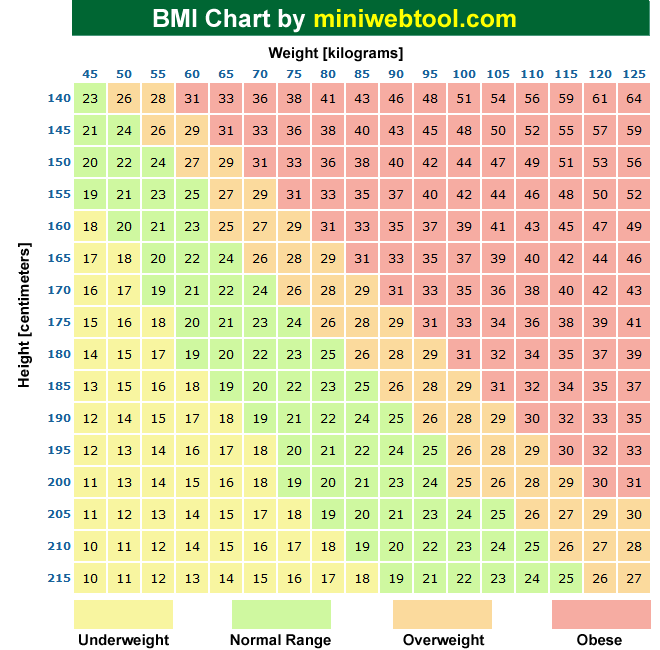

In [162]:
id_height = analisis_weight_tmp.columns.tolist().index("Height")
id_weight = analisis_weight_tmp.columns.tolist().index("Weight")

In [165]:
for row in range(len(analisis_weight_tmp)):
    height = analisis_weight_tmp.iloc[row, id_height]
    weight = analisis_weight_tmp.iloc[row, id_weight]
    
    height = height.split()[0]
    weight = weight.split()[0]
    
    analisis_weight_tmp.iloc[row, id_height] = height
    analisis_weight_tmp.iloc[row, id_weight] = weight

/tmp/ipykernel_45658/2804859119.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analisis_weight_tmp.iloc[row, id_height] = height
/tmp/ipykernel_45658/2804859119.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analisis_weight_tmp.iloc[row, id_weight] = weight


In [166]:
analisis_weight_tmp

,epizod,Name,Height,Weight
1116048,"GACAKд,AAGAAE15:06AAAA","GACAKд,",112.00,16.00
1116083,"GACAKд,AAMAAA09:23OBAA","GACAKд,",112.00,16.00
1351746,GACALaeAAGAAD15:32AAAA,GACALae,140.00,29.00
1351760,GACALaeAAGAAI14:08AgBS,GACALae,140.00,29.00
1351774,GACALaeAAKAAA09:25ABAA,GACALae,140.00,29.00
...,...,...,...,...
16516356,GACAjY/ACvAAA09:17ABAA,GACAjY/,150.00,44.00
16907540,GACAk5tACpAAX11:55AAAA,GACAk5t,67.00,6.50
16907720,GACAk5tAGwAAA11:29ABAA,GACAk5t,67.00,6.50
17965548,GACAnчiACDAAG13:39AAAA,GACAnчi,50.00,3.00


___________________________________________

#### Извлечем из dataset взвешивания 
Изучим сам набор данных

In [184]:
dataset = pd.read_csv("dataset.csv", index_col=0)

Important columns:
- Name
- MedicalProcessEventCode (в датасете с анализами аналогичный столбец называется "epizod")
- RecordEMC
- StartEpizode
- EndEpizode

In [185]:
columns_imp = ["Name", "MedicalProcessEventCode", "RecordEMC", "StartEpizode", "EndEpizode"]
dataset = dataset[columns_imp]
dataset

,Name,MedicalProcessEventCode,RecordEMC,StartEpizode,EndEpizode
4120,GACAACH,GACAACHABDAAA11:16BmAP,<w id='GACAI;' > <c id='AI~11;' > Состояние пи...,NaN,20160113.0
4215,GACAACH,GACAACHABFAAANABИaAkAS,<w id='GACAI;' > <c id='AI~11;' > Состояние пи...,NaN,20180219.0
4255,GACAACH,GACAACHABHAAA12:52AeAD,<w id='GACAB;' > <b> <c id='Ah~25;' > Хроничес...,20180206.0,20180220.0
4667,GACAACH,GACAACHABHAAG12:10AgAD,<w id='GACAu;' > <b> <c id='AG~25;' > Хроничес...,20180206.0,20180220.0
4678,GACAACH,GACAACHABHAAG12:10AkAS,<w id='GACRI;' > <c id='AH~10;' > Состояние пи...,20180206.0,20180220.0
...,...,...,...,...,...
11309984,GACBAкЪ,GACBAкЪAAWAAP17:38A!AA,<b>КЛИНИЧЕСКИЙ ДИАГНОЗ:</b><br/><br/><b>_ОСНОВ...,20201013.0,20201028.0
11309990,GACBAкЪ,GACBAкЪAAWAAP17:38A#AG,<w id='#ABVw;' > <c id='AO~34;' > Данные о МЭС...,20201013.0,20201028.0
11310216,GACBAкЪ,GACBAкЪAAaAAA12:40A!AA,<b>КЛИНИЧЕСКИЙ ДИАГНОЗ:</b><br/><b>Основной:</...,NaN,NaN
11317277,GACBAэы,GACBAэыAAEAAG10:58A(AB,<b>_СОПУТСТВУЮЩИЙ КЛИНИЧЕСКИЙ_ : </b><b>Код по...,20210407.0,20210416.0


In [240]:
dataset.iloc[3, 2]

"<w id='GACAu;' > <b> <c id='AG~25;' > Хронические заболевания в анамнезе </c> </b> : <v id='AG~25;' > ХОБЛ, хр.бронхит, ремиссия. Состояние после гемиколэктомии с передней резекцией прямой кишки в 2008 г.(Neo). Атеросклероз БЦА без значимого стенозирования. ОНМК 1990г. Кисты обеих почек. </v> : <c id='AGAC~28;' > стенокардия </c> <v id='AGAC~28;' > __III </v> ; <c id='AGAF~31;' > остеохондроз позвоночника </c> ; <v id='AGAT~45;' > резекция rectum, гемиколэктомия 2008г. Ожирение 2ст. </v> </w>"

Исследовать, какие могут быь вххождения по весу

Вес, кг : []

Вес [мусор] [] кг

In [236]:
weight_lst = []
height_lst = []
tmp_ind = dataset.columns.tolist().index("RecordEMC")

for i in range(len(dataset)):
    record = dataset.iloc[i, tmp_ind]
    weight = re.findall(r"Вес.+кг", record)
    height = re.findall(r"Рост \d+", record)

#     if len(weight) != 0:
#         weight = weight[0].split()[1]
#     else:
#         weight = np.nan

#     if len(height) != 0:
#         height = height[0].split()[1]
#     else:
#         height = np.nan
    
    weight_lst.append(weight)
    height_lst.append(height)

In [237]:
weight_lst

[["Вес </c> <v id='AIAA~12;' qqw=' 293:MSLves ;' > 78 , </v> кг"],
 ["Вес </c> <v id='AIAA~12;' qqw=' 293:MSLves ;' > 76 </v> <Mei id='AIAA~12;' > кг"],
 [],
 [],
 ["Вес </c> <v id='AHAA~11;' qqw=' 293:MSLves ;' > 76 </v> <Mei id='AHAA~11;' > кг"],
 ["Вес </c> <v id='AJAA~12;' qqw=' 293:MSLves ;' > 78 </v> <Mei id='AJAA~12;' > кг"],
 ['Вес 82 <sub> кг'],
 [],
 ['Вес 74 <sub> кг'],
 ['Вес 75 <sub> кг'],
 ['Вес 78 <sub> кг'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['Вес, кг'],
 ['Вес 110 <sub> кг'],
 ['Вес, кг'],
 ['Вес 105 <sub> кг'],
 ['Вес 102 <sub> кг'],
 [],
 ['Вес 105, <sub> кг'],
 ["Вес </c> <v id='AIAA~12;' qqw=' 293:MSLves ;' > 105, </v> <sub> кг"],
 ['Вес, кг'],
 ['Вес, кг'],
 ['Вес, кг'],
 [],
 ["Вес </c> <v id='AIAA~12;' qqw=' 293:MSLves ;' > 105, </v> кг"],
 ["Вес </c> <v id='AIAA~12;' qqw=' 293:MSLves ;' > 100, </v> кг"],
 ['Вес, кг'],
 ["Вес </c> <v id='AIAA~12;' qqw=' 293:MSLves ;' > 106, </v> кг"],
 ["Вес </c> <v id='AIAA~12;' qqw=' 293:MSLves ;' > 107 </v> <Mei id='AIAA~12

In [207]:
dataset["Weight"], dataset["Height"] = weight_lst, height_lst 

In [209]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48284 entries, 4120 to 11317289
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Name                     48284 non-null  object 
 1   MedicalProcessEventCode  48284 non-null  object 
 2   RecordEMC                48284 non-null  object 
 3   StartEpizode             41412 non-null  float64
 4   EndEpizode               42547 non-null  float64
 5   Weight                   4306 non-null   object 
 6   Height                   4278 non-null   object 
dtypes: float64(2), object(5)
memory usage: 4.0+ MB


In [210]:
dataset.to_csv("dataset_2.csv")

In [218]:
# посмотреть, как выглядят записи для одного пациента 
# (StartEpizode EndEpizode для всех записей данного пациента одинаковы?)

name = "GACAACH"
df_tmp = dataset[dataset["Name"] == name]
df_tmp.iloc[0, 2]

"<w id='GACAI;' > <c id='AI~11;' > Состояние питания </c> <v id='AI~11;' > удовлетворительное </v> : <c id='AIAA~12;' > Вес </c> <v id='AIAA~12;' qqw=' 293:MSLves ;' > 78 , </v> кг ; <c id='AIAB~13;' > Рост </c> <v id='AIAB~13;' qqw=' 293:MSLrost ;' > 159, </v> см ; <c id='AIAF~17;' > индекс массы тела </c> <v id='AIAF~17;' qqw=' 293:MSLteloM ;' > 30.83 </v> {ожирение I} ; <c id='AIAG~18;' > площадь поверхности тела </c> <v id='AIAG~18;' qqw=' 293:MSLteloS ;' > 1.86 </v> </w>"